<a href="https://colab.research.google.com/github/gitHubAndyLee2020/TF_Time_Series_Projects/blob/main/stock_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Reading the uploaded CSV file
for filename in uploaded.keys():
  # Use pandas to read the CSV file into a DataFrame
  df = pd.read_csv(filename)
  print(f"Data from {filename}:")
  print(df.head())

Saving netflix_stock_history.csv to netflix_stock_history (1).csv
Saving tesla_stock_history.csv to tesla_stock_history (1).csv
Saving amazon_stock_history.csv to amazon_stock_history (1).csv
Saving meta_stock_history.csv to meta_stock_history (1).csv
Saving microsoft_stock_history.csv to microsoft_stock_history (1).csv
Saving apple_stock_history.csv to apple_stock_history (1).csv
Data from netflix_stock_history (1).csv:
         Date Close/Last   Volume     Open     High        Low
0  08/25/2023    $416.03  5390933  $412.00  $419.25  $407.5641
1  08/24/2023    $406.93  5687799  $425.41  $427.59   $406.165
2  08/23/2023    $427.55  8174732  $418.40  $437.02    $417.71
3  08/22/2023    $413.17  3603273  $409.00  $415.74    $407.40
4  08/21/2023    $408.29  3861579  $402.23  $409.61    $399.50
Data from tesla_stock_history (1).csv:
         Date Close/Last     Volume       Open       High        Low
0  08/25/2023    $238.59  106612200    $231.31    $239.00    $230.35
1  08/24/2023    $23

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Modified read_and_format_csv_modified_with_window function to set 'Date' as the index
def read_and_format_csv_modified_with_window_date_index(file_directory, WINDOW_SIZE=5):
    """
    Reads a CSV file from a given directory, formats the "Date" column to numpy datetime64 format,
    calculates the average of "High" and "Low" into a new column named "Price",
    and adds windowed columns to the DataFrame.
    Sets the 'Date' column as the index to avoid errors during further processing.

    Parameters:
    - file_directory (str): The directory path of the CSV file.
    - WINDOW_SIZE (int): The size of the window for creating windowed columns.

    Returns:
    - df (pd.DataFrame): The formatted Pandas DataFrame with windowed columns and 'Date' as index.
    """
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_directory)

    # Convert the "Date" column to numpy datetime64 format
    df['Date'] = pd.to_datetime(df['Date'])

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    # List of columns to be formatted
    cols_to_format = ['Close/Last', 'Open', 'High', 'Low']

    # Remove dollar signs and convert to numeric format
    for col in cols_to_format:
        df[col] = pd.to_numeric(df[col].str.replace('$', ''), errors='coerce')

    # Drop the "Close/Last" and "Open" columns
    df.drop(['Close/Last', 'Open'], axis=1, inplace=True)

    # Calculate the average of "High" and "Low" into a new column "Price"
    df['Price'] = (df['High'] + df['Low']) / 2

    # Drop the "High" and "Low" columns
    df.drop(['High', 'Low'], axis=1, inplace=True)

    # Add windowed columns
    for i in range(WINDOW_SIZE):
        df[f"Price+{i+1}"] = df["Price"].shift(periods=i+1)

    return df.dropna()

# Sample usage (assuming the file is located at 'your_file_directory_here.csv')
# formatted_df_with_window_date_index = read_and_format_csv_modified_with_window_date_index('your_file_directory_here.csv', WINDOW_SIZE=5)
# print(formatted_df_with_window_date_index.head())

In [ ]:
# Modified create_datasets function to take DataFrame as a parameter and compute X and y
def create_datasets_from_df(df, BATCH_SIZE=1024):
    """
    Create train, test, and validation sets from a DataFrame and prepare them for training.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the stock data with windowed columns.
    - BATCH_SIZE (int): Batch size for training

    Returns:
    - train_dataset (tf.data.Dataset): Training dataset
    - test_dataset (tf.data.Dataset): Test dataset
    - val_dataset (tf.data.Dataset): Validation dataset
    """
    # Compute X and y from DataFrame
    X = df.dropna().drop("Price", axis=1).values.astype(np.float32)
    y = df.dropna()["Price"].values.astype(np.float32)

    # Calculate split sizes
    total_size = len(X)
    train_size = int(total_size * 0.8)
    test_size = int(total_size * 0.1)

    # Split data into train, test, and validation sets
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:train_size + test_size], y[train_size:train_size + test_size]
    X_val, y_val = X[train_size + test_size:], y[train_size + test_size:]

    # Turn train, test, and validation arrays into tensor Datasets
    train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
    train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

    test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
    test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

    val_features_dataset = tf.data.Dataset.from_tensor_slices(X_val)
    val_labels_dataset = tf.data.Dataset.from_tensor_slices(y_val)

    # Combine features & labels
    train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
    test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))
    val_dataset = tf.data.Dataset.zip((val_features_dataset, val_labels_dataset))

    # Batch and prefetch for optimal performance
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset, val_dataset, X_train, X_test, y_train, y_test

# Sample usage
# Assuming df is your DataFrame containing the stock data with windowed columns
# BATCH_SIZE = 1024
# train_dataset, test_dataset, val_dataset = create_datasets_from_df(df, BATCH_SIZE)

In [ ]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Modifying the plot_stock_data function to use DataFrame index (Date) for plotting and add legends for "Volume" and "Price"
def plot_stock_data_modified_with_legend_and_date_index(df):
    """
    Plots the "Volume" and "Price" values as y-values against the DataFrame index (Date) as x-values.
    Adds legends for "Volume" and "Price".

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the stock data.
    """
    # Setting the plot size
    plt.figure(figsize=(14, 8))

    # Get separate y-axes for "Volume" and "Price"
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plotting "Volume" values
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Volume', color=color)
    line1, = ax1.plot(df.index, df['Volume'], label='Volume', linewidth=2, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis to plot "Price"
    ax2 = ax1.twinx()

    # Plotting "Price" values
    color = 'tab:red'
    ax2.set_ylabel('Price', color=color)
    line2, = ax2.plot(df.index, df['Price'], label='Price', linewidth=2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Adding title
    plt.title('Volume and Price Over Time')

    # Adding grid for better visibility
    ax1.grid(True)

    # Adding legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc=0)

    # Show the plot
    plt.show()

# Sample DataFrame for demonstration (assuming df is a DataFrame with 'Date' as index, and 'Volume' and 'Price' as columns)
# df = pd.DataFrame({
#     'Date': pd.date_range(start='2023-08-01', periods=5, freq='D'),
#     'Volume': np.random.randint(1000, 5000, 5),
#     'Price': np.random.uniform(400, 450, 5)
# })
# df.set_index('Date', inplace=True)

# Sample usage
# plot_stock_data_modified_with_legend_and_date_index(df)

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
apple_stock_history = read_and_format_csv_modified_with_window_date_index("apple_stock_history.csv", WINDOW_SIZE)
apple_stock_history.tail()

<ipython-input-55-bb0f8ccbc808>:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = pd.to_numeric(df[col].str.replace('$', ''), errors='coerce')


,Volume,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-09-03,331867627,17.64200,17.83075,17.75570,17.66660,18.06070,17.80265,16.75895,16.81090
2013-08-30,272214407,17.49020,17.64200,17.83075,17.75570,17.66660,18.06070,17.80265,16.75895
2013-08-29,239216868,17.63625,17.49020,17.64200,17.83075,17.75570,17.66660,18.06070,17.80265
2013-08-28,306986837,17.53210,17.63625,17.49020,17.64200,17.83075,17.75570,17.66660,18.06070
2013-08-27,423386991,17.65735,17.53210,17.63625,17.49020,17.64200,17.83075,17.75570,17.66660


<Figure size 1400x800 with 0 Axes>

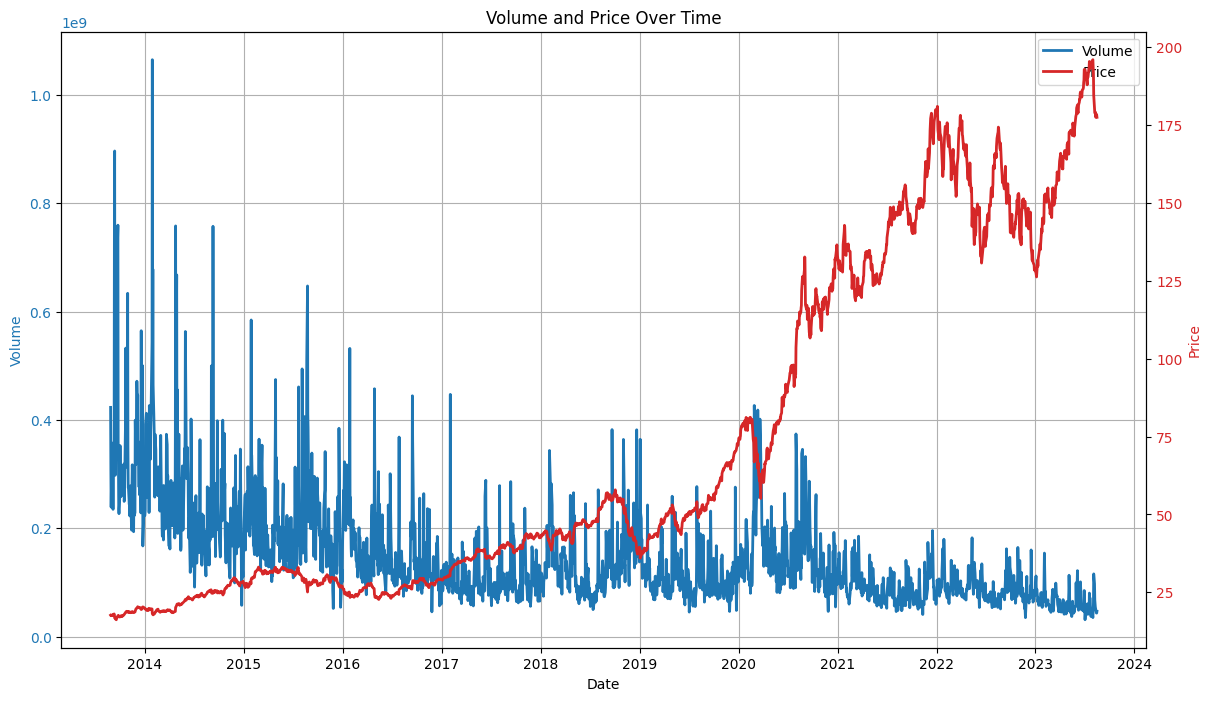

In [ ]:
plot_stock_data_modified_with_legend_and_date_index(apple_stock_history)

> Model 0

- Baseline model using Naive Forecast.
- predicted y_t = y_t-1

In [ ]:
apple_train_dataset, apple_test_dataset, apple_val_dataset, apple_X_train, apple_X_test, apple_y_train, apple_y_test = create_datasets_from_df(apple_stock_history, BATCH_SIZE)

In [ ]:
# Create a naïve forecast
apple_naive_forecast = apple_y_test[:-1] # Naïve forecast equals every value excluding the last value
apple_naive_forecast[:10], apple_naive_forecast[-10:] # View frist 10 and last 10

(array([25.1    , 27.1931 , 28.2475 , 28.9    , 29.18125, 29.14375,
        28.79   , 28.8675 , 28.13125, 28.93875], dtype=float32),
 array([24.85875, 24.9025 , 24.67   , 24.7125 , 24.735  , 25.2225 ,
        25.8075 , 25.6375 , 25.5425 , 25.40875], dtype=float32))

In [ ]:
apple_naive_results = evaluate_preds(y_true=apple_y_test[1:],
                               y_pred=apple_naive_forecast)
apple_naive_results

{'mae': 0.28773084,
 'mse': 0.15851152,
 'rmse': 0.39813507,
 'mape': 0.98705775,
 'mase': 1.0258502}

> Model 1

- Combination model with various loss functions.
- Implemented using simple dense layers.
- WINDOW_SIZE = 7
- HORIZON = 1

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1
BATCH_SIZE = 1024

In [ ]:
def get_ensemble_models(train_data,
                        test_data,
                        horizon=HORIZON,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [ ]:
ensemble_models = get_ensemble_models(train_data=apple_train_dataset,
                                      test_data=apple_val_dataset,
                                      num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 110: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 316: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 437: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 625: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 725: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 218: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 318: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 265: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 151: 

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
apple_ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                           data=apple_test_dataset)
apple_ensemble_preds

1/1 [==============================] - 0s 10ms/step


<tf.Tensor: shape=(15, 251), dtype=float32, numpy=
array([[-2.4002962e+01,  1.7997038e+01,  3.1997038e+01, ...,
         6.9997040e+01,  4.0497040e+01,  2.5997038e+01],
       [ 6.3999504e+01,  7.9995036e+00,  7.9995036e+00, ...,
        -4.0000496e+01, -1.2000496e+01,  3.9995039e+00],
       [ 1.1606400e+05,  9.1216000e+04,  4.8912000e+04, ...,
         4.9024000e+04,  3.3584000e+04,  2.3768000e+04],
       ...,
       [ 1.2575999e+04,  9.9039990e+03,  5.2399995e+03, ...,
         5.2879995e+03,  3.5679995e+03,  2.4879995e+03],
       [ 3.1998791e+01, -1.2094976e-03, -1.2094976e-03, ...,
        -3.2001209e+01,  2.3998791e+01,  3.1998791e+01],
       [-3.1680012e+03, -2.3040012e+03, -1.2280012e+03, ...,
        -1.2960012e+03, -8.2800122e+02, -5.9600122e+02]], dtype=float32)>

In [ ]:
# Evaluate ensemble model(s) predictions
apple_ensemble_results = evaluate_preds(y_true=apple_y_test,
                                        y_pred=np.median(apple_ensemble_preds, axis=0)) # take the median across all ensemble predictions
apple_ensemble_results

{'mae': 15.002632,
 'mse': 352.04587,
 'rmse': 18.762886,
 'mape': 51.618637,
 'mase': 52.1412}